In [1]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install jsmetrics

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [5]:
import xarray as xr
import numpy as np
import cftime
import matplotlib.pyplot as plt
import jsmetrics
import pandas as pd
import jsmetrics.metrics.jet_statistics as jet_statistics
def lineplot_setup(xmin,xmax,xlab,ylab,ymin=None,ymax=None,title=None,legend=False):
    # especificar limites minimos y maximos del grafico
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    # cuadrilla interna del grafico
    plt.grid(linestyle='--',alpha=0.66)
    plt.minorticks_on()
    # hacer las etiquetas de ambos ejes mas grandes
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel(xlab,fontsize=10)
    plt.ylabel(ylab,fontsize=10)
    plt.title(title,fontsize=11)
    if legend:
        plt.legend(fancybox=True,shadow=True,fontsize=8)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [6]:
#Cargando datos históricos
uahist="ua_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_195001-201412.nc"
vahist='va_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_195001-201412.nc'
uahisto=xr.open_dataset(uahist)
vahisto=xr.open_dataset(vahist)

#Seleccionando nuestra variable de interés
ua=uahisto["ua"]
va=vahisto["va"]

In [7]:
#Cargando datos simulados
uasim="ua_Amon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_205001-210012.nc"
vasim='va_Amon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_205001-210012.nc'
uas=xr.open_dataset(uasim)
vas=xr.open_dataset(vasim)

#Seleccionando nuestra variable de interés
uasi=uas["ua"]
vasi=vas["va"]

In [8]:
#Checando las unidades de la presión
uasi["plev"].units

'Pa'

In [9]:
#Dado que las unidades de la presión se encuentran en Pa, estas se pasarán a hPa
#Histórico
ua["plev"]=ua["plev"]/100
va["plev"]=va["plev"]/100
#Simulado
uasi["plev"]=uasi["plev"]/100
vasi["plev"]=vasi["plev"]/100

In [10]:
#Cambiando las unidades
#Histórico
ua['units']='hPa'
va['units']='hPa'

#Simulado
uasi['units']='hPa'
vasi['units']='hPa'

In [11]:
#Ahora se hará un recorte para nuestra área de interés, en esta caso abarcará una latitud de 10 a 40 N y una longitud de -67 a -129 W

#Históricos
ua=ua.sel(lat=slice(10, 40),lon=slice(360-129,360-67))
va=va.sel(lat=slice(10,40),lon=slice(360-129,360-67))

#Simulados
uasi=uasi.sel(lat=slice(10, 40),lon=slice(360-129,360-67))
vasi=vasi.sel(lat=slice(10,40),lon=slice(360-129,360-67))

In [12]:
#Recorte para la temporada invernal en el hemisferio norte

#Históricos
ua=ua.where((ua.time.dt.month==12)| (ua.time.dt.month==1)| (ua.time.dt.month==2),drop=True)
va=va.where((va.time.dt.month==12)| (va.time.dt.month==1)| (va.time.dt.month==2),drop=True)

#Simulados
uasi=uasi.where((uasi.time.dt.month==12)| (uasi.time.dt.month==1)| (uasi.time.dt.month==2),drop=True)
vasi=vasi.where((vasi.time.dt.month==12)| (vasi.time.dt.month==1)| (vasi.time.dt.month==2),drop=True)

In [13]:
#Recorte para el periodo de tiempo de los datos históricos que necesitamos, es decir, de 1979 a 2014
ua=ua.where(ua.time.dt.year>1978 ,drop=True)
va=va.where(va.time.dt.year>1978 ,drop=True)

#Recorte para el periodo de tiempo de los datos simulados que necesitamos, es decir, de 2070 a 2100
uasi=uasi.where(uasi.time.dt.year>2069 ,drop=True)
vasi=vasi.where(vasi.time.dt.year>2069 ,drop=True)

In [14]:
#Para analizar la posición del jet Subtropical se usará la paquetería de jsmetrics, para ello es necesario convertir el tiempo a gregoriano para que pueda funcionar

#Histórico
ua=ua.convert_calendar(calendar ='gregorian',align_on="year")

#Simulado
uasi=uasi.convert_calendar(calendar ='gregorian',align_on="year")

In [15]:
#Ahora usaremos la parte de jsmetrics statistics para poder encontrar la posición promedio y la intensidad, para ello se usará el método de Woollings et al. 2010
#Para ello necesitamos definir el nivel de altura al que queremos que se efectúe el cálculo, en este caso a 200 hPa

#Histórico
historico = jsmetrics.jet_statistics.woollings_et_al_2010(\
                    ua.sel(\
                           plev=200),\
                    filter_freq=4, window_size=20)

#Simulado
simulado=jsmetrics.jet_statistics.woollings_et_al_2010(\
                    uasi.sel(\
                           plev=200),\
                    filter_freq=4, window_size=20)

In [32]:
#Viendo nuestros resultados
historico

<xarray.Dataset> Size: 14kB
Dimensions:       (lat: 25, time: 108, season: 1)
Coordinates:
  * lat           (lat) float64 200B 10.0 11.25 12.5 13.75 ... 37.5 38.75 40.0
    plev          float64 8B 200.0
    units         <U3 12B 'hPa'
  * time          (time) datetime64[ns] 864B 1979-01-16 ... 2014-12-17
Dimensions without coordinates: season
Data variables:
    ua            (time, lat) float32 11kB 14.8 14.86 14.96 ... 41.56 38.6 35.33
    jet_lat       (time) float64 864B 38.75 38.75 28.75 27.5 ... 32.5 30.0 31.25
    jet_speed     (time) float64 864B 90.24 80.38 81.66 ... 95.45 89.4 98.34
    ff_jet_lat    (season) float64 8B 32.0
    ff_jet_speed  (season) float64 8B 88.53

In [17]:
#Viendo nuestros resultados
simulado

<xarray.Dataset> Size: 12kB
Dimensions:       (lat: 25, time: 93, season: 1)
Coordinates:
  * lat           (lat) float64 200B 10.0 11.25 12.5 13.75 ... 37.5 38.75 40.0
    plev          float64 8B 200.0
    units         <U3 12B 'hPa'
  * time          (time) datetime64[ns] 744B 2070-01-16 ... 2100-12-17
Dimensions without coordinates: season
Data variables:
    ua            (time, lat) float32 9kB 7.108 9.196 11.46 ... 45.44 40.74
    jet_lat       (time) float64 744B 32.5 30.0 27.5 31.25 ... 30.0 31.25 33.75
    jet_speed     (time) float64 744B 119.3 106.5 71.23 ... 131.6 109.7 113.2
    ff_jet_lat    (season) float64 8B 30.31
    ff_jet_speed  (season) float64 8B 104.1

In [18]:
# Ahora se realizará un promedio estacional por año para la variable de jet_lat y jet_speed

#Posición
historicop=historico["jet_lat"].groupby(historico["jet_lat"].time.dt.year).mean()  #Histórico
simuladop=simulado["jet_lat"].groupby(simulado["jet_lat"].time.dt.year).mean()  #Simulado

#Velocidad
historicov=historico["jet_speed"].groupby(historico["jet_speed"].time.dt.year).mean()  #Histórico
simuladov=simulado["jet_speed"].groupby(simulado["jet_speed"].time.dt.year).mean()  #Simulado

In [19]:
historicop

<xarray.DataArray 'jet_lat' (year: 36)> Size: 288B
array([35.41666667, 30.41666667, 35.        , 32.08333333, 32.5       ,
       31.66666667, 30.41666667, 29.58333333, 32.91666667, 32.5       ,
       32.08333333, 32.5       , 30.83333333, 28.75      , 30.        ,
       33.33333333, 30.        , 30.        , 31.66666667, 32.08333333,
       31.25      , 32.91666667, 32.5       , 31.25      , 33.75      ,
       30.        , 35.41666667, 31.25      , 32.91666667, 36.25      ,
       31.66666667, 32.08333333, 28.33333333, 32.5       , 35.        ,
       31.25      ])
Coordinates:
    plev     float64 8B 200.0
    units    <U3 12B 'hPa'
  * year     (year) int64 288B 1979 1980 1981 1982 1983 ... 2011 2012 2013 2014

In [20]:
#Calculando la varianza de la posición del jet y el promedio de latitud del periodo histórico y simulado
#El promedio de la latitud durante todo el periodo ya está calculado por la varibale ff_jet_lat
#Los valores se redondearan a los cifras

#Histósrico
varh=historicop.var().round(2)
proh=historico["ff_jet_lat"].round(2)

#Simulado
vars=simuladop.var().round(2)
pros=simulado["ff_jet_lat"].round(2)

In [21]:
simuladop

<xarray.DataArray 'jet_lat' (year: 31)> Size: 248B
array([30.        , 31.66666667, 33.75      , 30.        , 30.83333333,
       30.41666667, 28.75      , 35.        , 29.58333333, 27.91666667,
       29.58333333, 30.        , 29.58333333, 30.83333333, 34.16666667,
       30.        , 28.33333333, 30.        , 27.91666667, 30.41666667,
       30.83333333, 31.25      , 29.58333333, 30.        , 28.75      ,
       31.66666667, 29.16666667, 29.58333333, 29.16666667, 29.16666667,
       31.66666667])
Coordinates:
    plev     float64 8B 200.0
    units    <U3 12B 'hPa'
  * year     (year) int64 248B 2070 2071 2072 2073 2074 ... 2097 2098 2099 2100

In [22]:
#Calculando la varianza de la velocidad del jet y el promedio de velocidad del periodo histórico y simulado
#Para la velocidad la variable es jet_speed, el promedio de la velocidad durante todo el periodo ya está calculado por la varibale ff_jet_speed
#Los valores se redondearan a los cifras

#Histósrico
vvarh=historicov.var().round(2)
vproh=historico["ff_jet_speed"].round(2)

#Simulado
vvars=simuladov.var().round(2)
vpros=simulado["ff_jet_speed"].round(2)

In [23]:
print(vproh,vpros)

<xarray.DataArray 'ff_jet_speed' (season: 1)> Size: 8B
array([88.53])
Coordinates:
    plev     float64 8B 200.0
    units    <U3 12B 'hPa'
Dimensions without coordinates: season <xarray.DataArray 'ff_jet_speed' (season: 1)> Size: 8B
array([104.05])
Coordinates:
    plev     float64 8B 200.0
    units    <U3 12B 'hPa'
Dimensions without coordinates: season


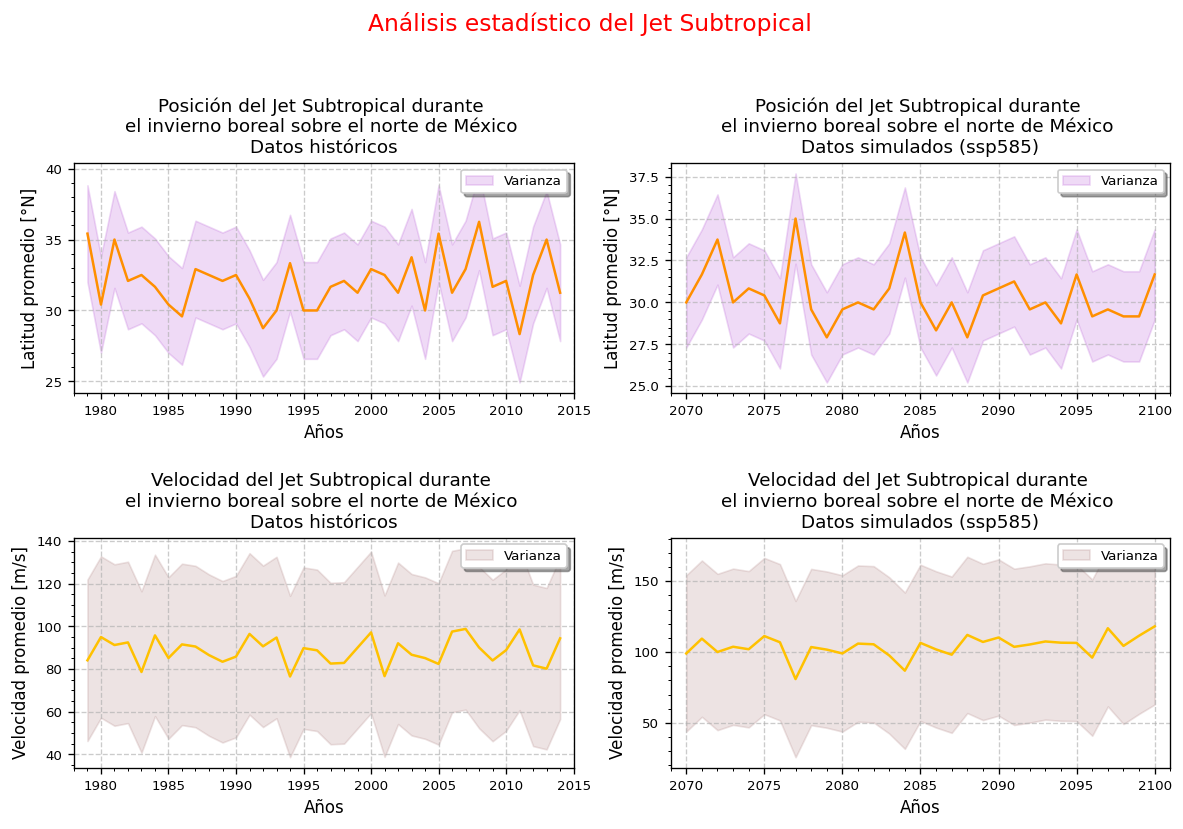

In [24]:
#Graficando nuestros resultados

#Orden en el que queremos que vayan nuestras gráficas
graf=[historicop,simuladop,historicov,simuladov]
grafvar=[varh,vars,vvarh,vvars]
colors=["#FF8F00","#FF8F00","#FFC100","#FFC100"]
colorf=["#AF47D2","#AF47D2","#A87676","#A87676"]
eje=["Latitud promedio [°N]", "Latitud promedio [°N]","Velocidad promedio [m/s]","Velocidad promedio [m/s]"]
titulo=[["Datos históricos", "Posición"],["Datos simulados (ssp585)", "Posición"],["Datos históricos", "Velocidad"],["Datos simulados (ssp585)", "Velocidad"]]
#grafprom=[proh,pros,vproh,vpros]
fig = plt.figure(figsize=(10, 7),dpi=120)
for i,value in enumerate(graf):
    
    # hacer el objeto multi-panel y seleccionar el panel correcto con el indice que varia en el ciclo iseason
    ax = fig.add_subplot(2, 2, 1+i)
    ax.plot(value.year,value,color=colors[i])
    ax.fill_between(value.year,value+grafvar[i], value-grafvar[i], alpha=0.2,color=colorf[i],label="Varianza")
    lineplot_setup(value.year.min()-1,value.year.max()+1,"Años",eje[i],ymin=None,ymax=None,title=(f"{titulo[i][1]} del Jet Subtropical durante \nel invierno boreal sobre el norte de México \n{titulo[i][0]}"),legend=True)
    plt.tight_layout()
        
    
# ultimo arreglo, apretar el mapa
plt.tight_layout(h_pad=3)
plt.subplots_adjust(top=0.8)
fig.suptitle("Análisis estadístico del Jet Subtropical\n",fontsize=14,color="red");
plt.savefig("Estadística.png", bbox_inches='tight')

Ahora encontraremos la distribución de densidad para los datos de posición y velocidad del viento para ambas simulaciones

In [25]:
d_lat={'posición del Jet Subtropical sobre el Norte de México durante el invierno boreal\n Datos históricos(1979-2014)':historico["jet_lat"],'posición del Jet Subtropical sobre el Norte de México durante el invierno boreal\n Datos escenario ssp585(2070-2100)':simulado["jet_lat"]}
d_vel={'velocidad del Jet Subtropical sobre el Norte de México durante el invierno boreal\n Datos históricos(1979-2014)':historico["jet_speed"],'velocidad del Jet Subtropical sobre el Norte de México durante el invierno boreal\n Datos escenario ssp585(2070-2100)':simulado["jet_speed"]}

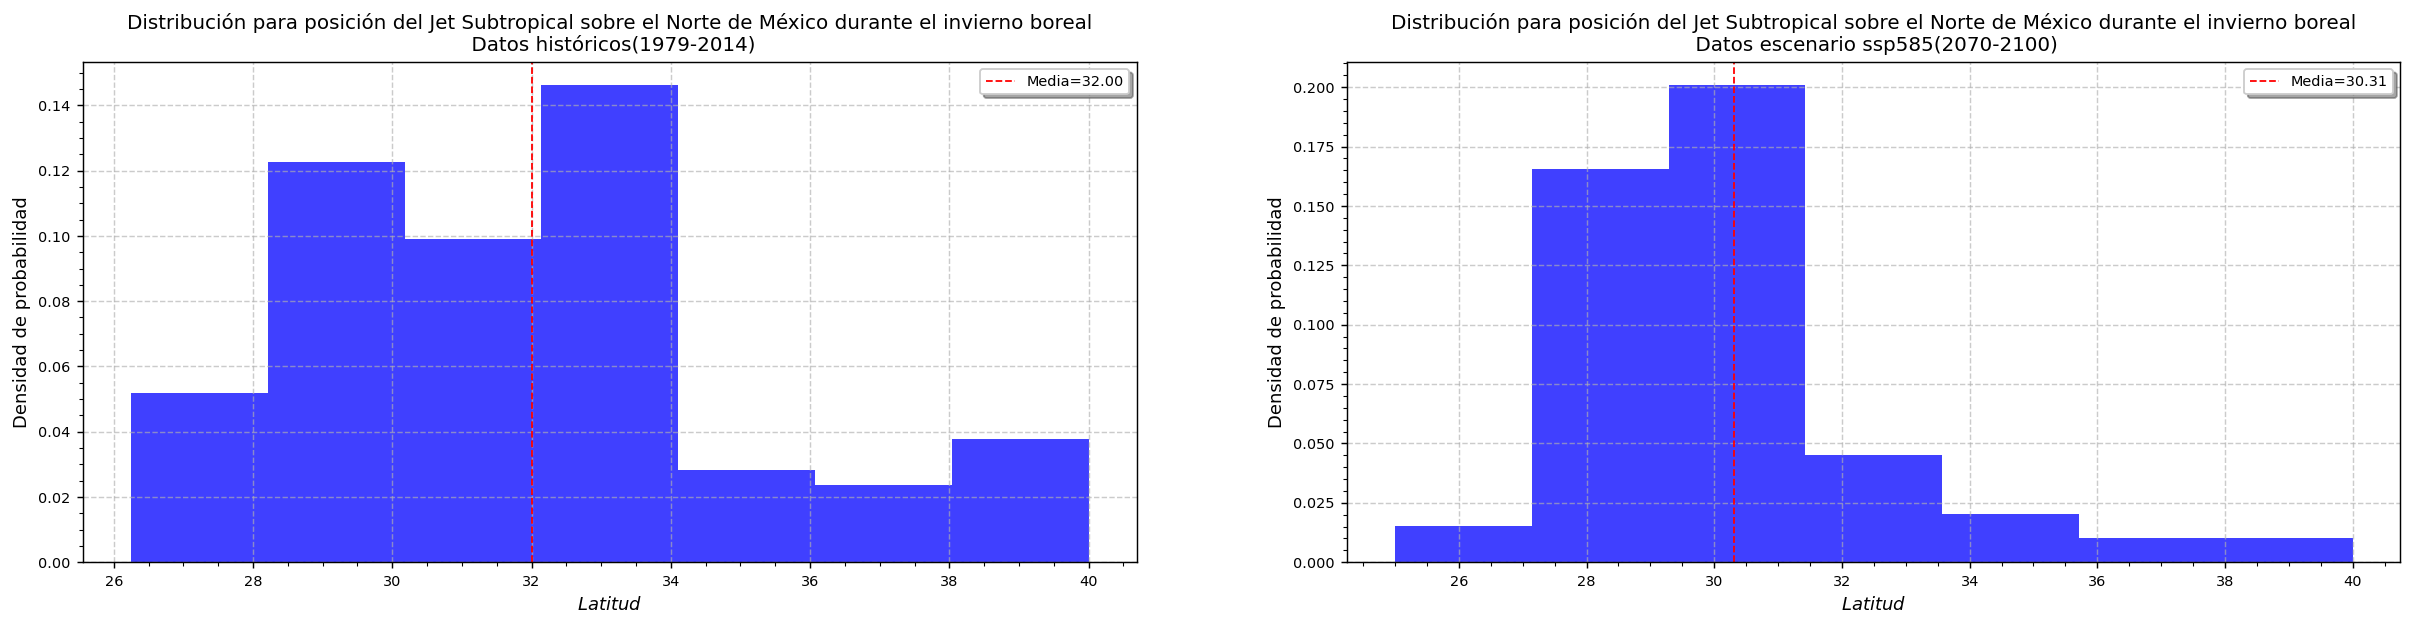

In [26]:
dics=[d_lat]
j=0
for dic in dics:
    i=1
    plt.figure(figsize=(23,5),dpi=130)
    for k,v in dic.items():
        plt.subplot(1,len(dic),i)
        valores_M=v.data.flatten()
        plt.hist(valores_M, 7, density=True, histtype='stepfilled', facecolor='b',alpha=0.75)
        #punto 3
        media=v.mean()
        plt.axvline(media,color = "red", linewidth = 1, linestyle = "dashed",label=f'Media={media.values:.2f}')
        if j==2:
            x_name='$Latitud$'
        elif j==0:
            x_name='$Latitud$'
        else:
            x_name='$Velocidad[m/s$'
        lineplot_setup(None,None,x_name,'Densidad de probabilidad',title=f'Distribución para {k}',legend=True)
        i+=1
    j+=1
    #plt.savefig("Densidad.png", bbox_inches='tight')
    plt.show()


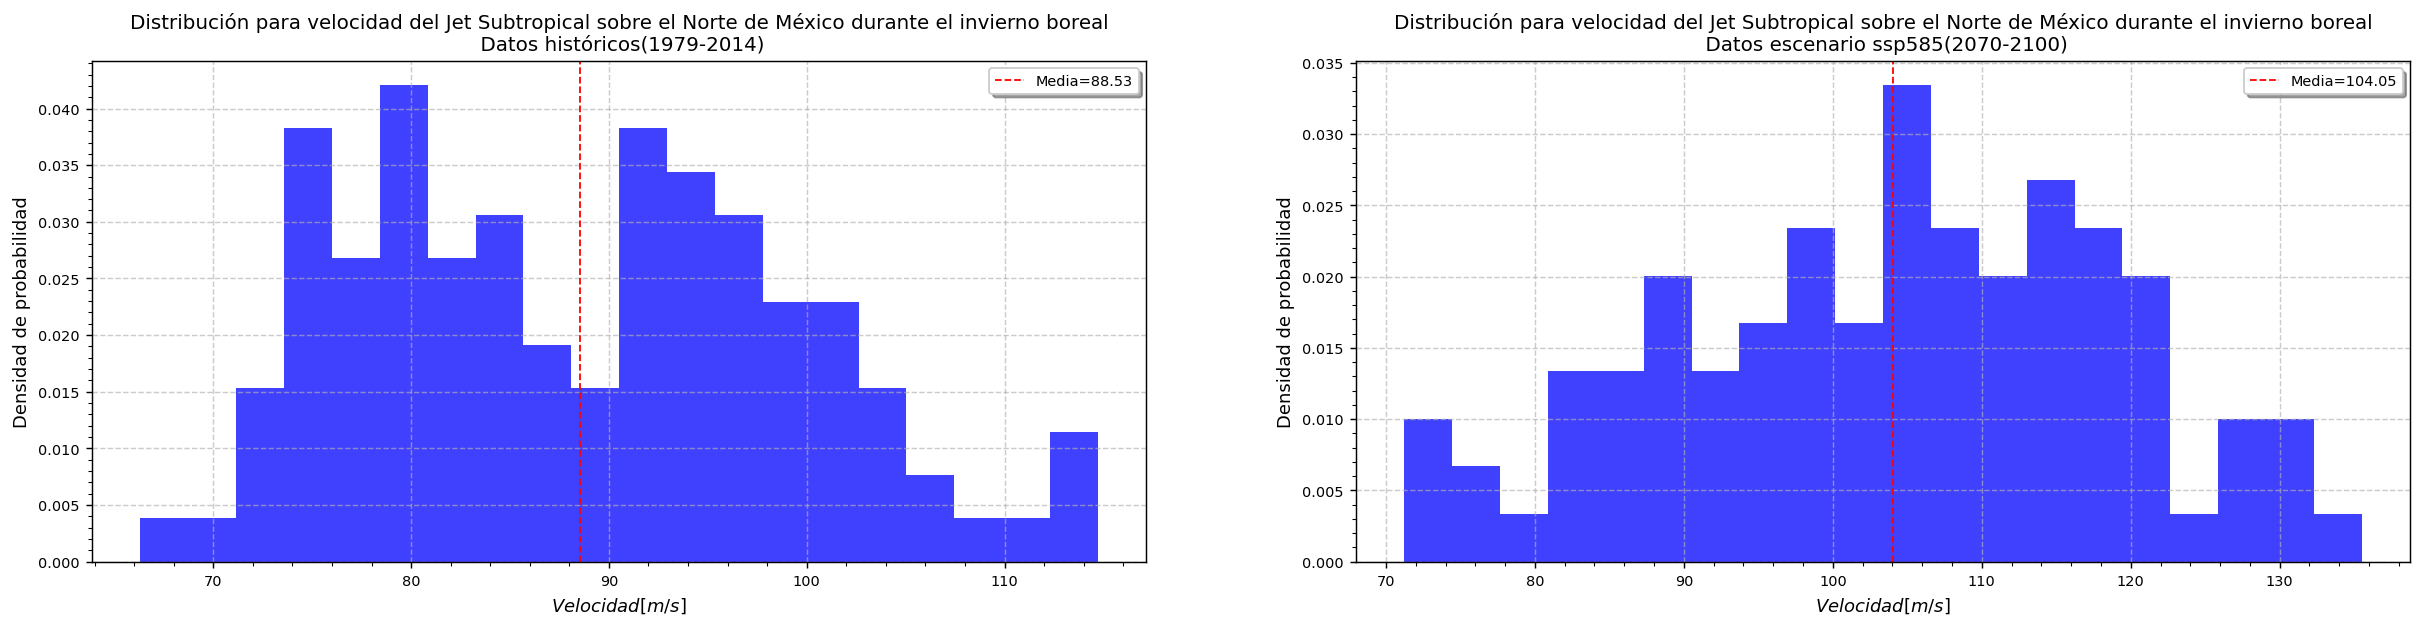

In [27]:
dics=[d_vel]
j=0
for dic in dics:
    i=1
    plt.figure(figsize=(23,5),dpi=130)
    for k,v in dic.items():
        plt.subplot(1,len(dic),i)
        valores_M=v.data.flatten()
        plt.hist(valores_M, 20, density=True, histtype='stepfilled', facecolor='b',
                   alpha=0.75)
        #punto 3
        media=v.mean()
        plt.axvline(media,color = "red", linewidth = 1, linestyle = "dashed",label=f'Media={media.values:.2f}')
        if j==2:
            x_name='$Velocidad [m/s]$'
        elif j==0:
            x_name='$Velocidad [m/s]$'
        else:
            x_name='$Velocidad[m/s]$'
        lineplot_setup(None,None,x_name,'Densidad de probabilidad',title=f'Distribución para {k}',legend=True)
        i+=1
    j+=1
    #plt.savefig("Densidadvel.png", bbox_inches='tight')
    plt.show()